In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# If you use the Kaggle platform, your code would start from here, otherwise uncomment lines 1 and 2 of the following code block.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard-fraud-detection/cc_info.csv
/kaggle/input/creditcard-fraud-detection/transactions.csv


In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest # Identifica transacciones inusuales
import matplotlib.pyplot as plt

1. **ETL**

In [5]:
# Load Data
df_info = pd.read_csv("/kaggle/input/creditcard-fraud-detection/cc_info.csv")
df_transactions = pd.read_csv("/kaggle/input/creditcard-fraud-detection/transactions.csv")

In [6]:
df_info.head()

credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000

In [7]:
df_transactions.head()

credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat  
0 -80.174132  40.267370  
1 -80.194240  40.180114  
2 -80.211033  40.313004  
3 -80.174138  40.290895  
4 -80.238720  40.166719

In [8]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [9]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [10]:
# Merge data
merged_data = pd.merge(df_transactions, df_info, on='credit_card', how='left')
merged_data.head()

credit_card                 date  transaction_dollar_amount  \
0  1003715054175576  2015-09-11 00:32:40                      43.78   
1  1003715054175576  2015-10-24 22:23:08                     103.15   
2  1003715054175576  2015-10-26 18:19:36                      48.55   
3  1003715054175576  2015-10-22 19:41:10                     136.18   
4  1003715054175576  2015-10-26 20:08:22                      71.82   

        Long        Lat     city state  zipcode  credit_card_limit  
0 -80.174132  40.267370  Houston    PA    15342              20000  
1 -80.194240  40.180114  Houston    PA    15342              20000  
2 -80.211033  40.313004  Houston    PA    15342              20000  
3 -80.174138  40.290895  Houston    PA    15342              20000  
4 -80.238720  40.166719  Houston    PA    15342              20000

2. **EDA**

In [11]:
# Check for missing values or null data
print(merged_data.isnull().sum())

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64


In [12]:
# Feature Engineering: Extracts information from the date column to identify hourly or daily patterns
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['hour'] = merged_data['date'].dt.hour
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

In [13]:
# Initialize geolocator
geolocator = Nominatim(user_agent="fraud_detection")

In [14]:
# Function to obtain the coordinates of a city
def get_coordinates(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

In [15]:
# Obtain the coordinates of the cities present in the dataset
unique_cities = merged_data['city'].unique()
city_coords = {city: get_coordinates(city) for city in unique_cities}

In [16]:
# Merge with the original DataFrame
merged_data['city_lat'] = merged_data['city'].map(lambda x: city_coords[x][0])
merged_data['city_lon'] = merged_data['city'].map(lambda x: city_coords[x][1])

In [17]:
# Delete rows where coordinates could not be obtained
merged_data = merged_data.dropna(subset=['city_lat', 'city_lon'])

In [18]:
# Calculate the distance between the cardholder's city and the transaction
merged_data['distance_to_city_km'] = merged_data.apply(
    lambda row: geodesic((row['city_lat'], row['city_lon']), (row['Lat'], row['Long'])).km,
    axis=1
)

In [19]:
# Amount/limit ratio
merged_data['amount_to_limit'] = merged_data['transaction_dollar_amount'] / merged_data['credit_card_limit']

In [20]:
# Group transactions by Long and Lat to identify specific geographic regions where anomalous transactions are more frequent
kmeans = KMeans(n_clusters=5, random_state=42)
merged_data['location_cluster'] = kmeans.fit_predict(merged_data[['Long', 'Lat']])

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3. **Preprocessing**

In [21]:
# Coding categorical variables
merged_data = pd.get_dummies(merged_data, columns=['state'], drop_first=True)

In [22]:
# Scaling numerical features
scaler = StandardScaler()
numeric_cols = ['transaction_dollar_amount', 'credit_card_limit', 'amount_to_limit']
merged_data[numeric_cols] = scaler.fit_transform(merged_data[numeric_cols])

In [23]:
# Select features
X = merged_data.drop(['credit_card', 'city', 'date', 'Long', 'Lat', 'city_lat', 'city_lon', 'zipcode'], axis=1)

4. **Modelado**

In [24]:
# Train Model
iso_forest = IsolationForest(contamination=0.01, random_state=42) # 1% de anomalias esperadas
iso_forest.fit(X)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, random_state=42)

In [25]:
# Predict anomalies
merged_data['is_anomaly'] = iso_forest.predict(X)
merged_data['is_anomaly'] = merged_data['is_anomaly'].map({1: 0, -1: 1}) # 1: anomalia, 0: normal

5. **Analyze the results**

In [26]:
# Proportion of anomalies for cluster
anomaly_by_cluster = merged_data.groupby('location_cluster')['is_anomaly'].mean()
print(anomaly_by_cluster)

location_cluster
0    0.004611
1    0.059318
2    0.038310
3    0.399061
4    0.125413
Name: is_anomaly, dtype: float64


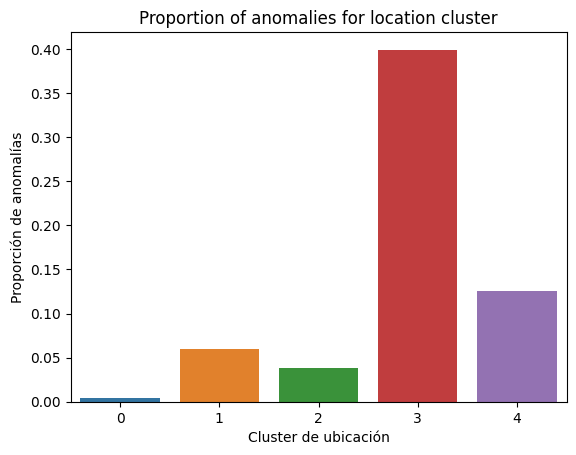

In [36]:
# View anomalies
sns.barplot(x=anomaly_by_cluster.index, y=anomaly_by_cluster.values)
plt.xlabel('Cluster de ubicación')
plt.ylabel('Proporción de anomalías')
plt.title('Proportion of anomalies for location cluster')
plt.show()

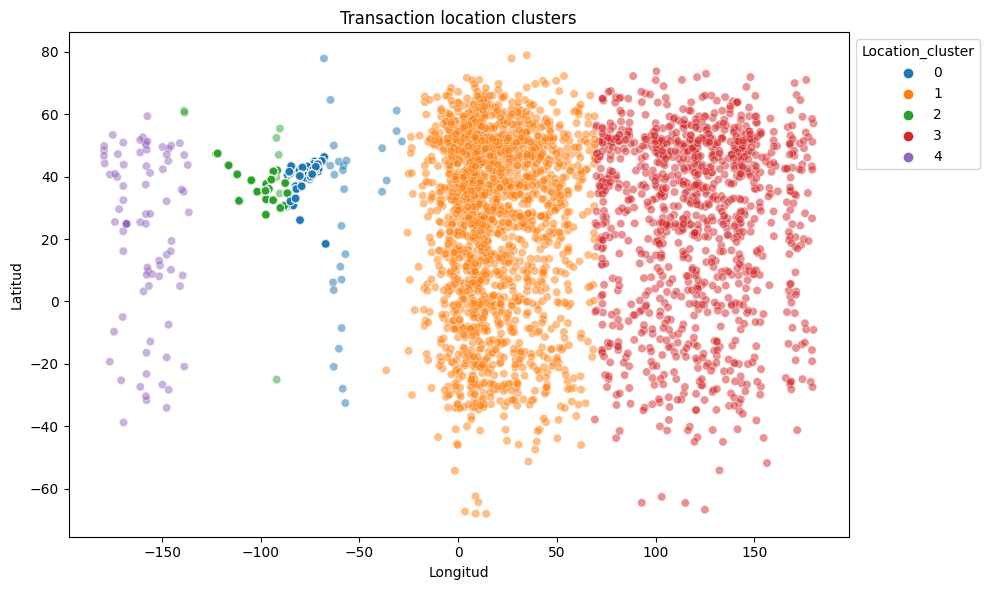

In [37]:
# Visualize clusters in the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Long', y='Lat', hue='location_cluster', data=merged_data, palette='tab10', alpha=0.5)

plt.legend(title= 'Location_cluster',bbox_to_anchor=(1.00, 1), loc=2)

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Transaction location clusters')

plt.tight_layout()

plt.show()

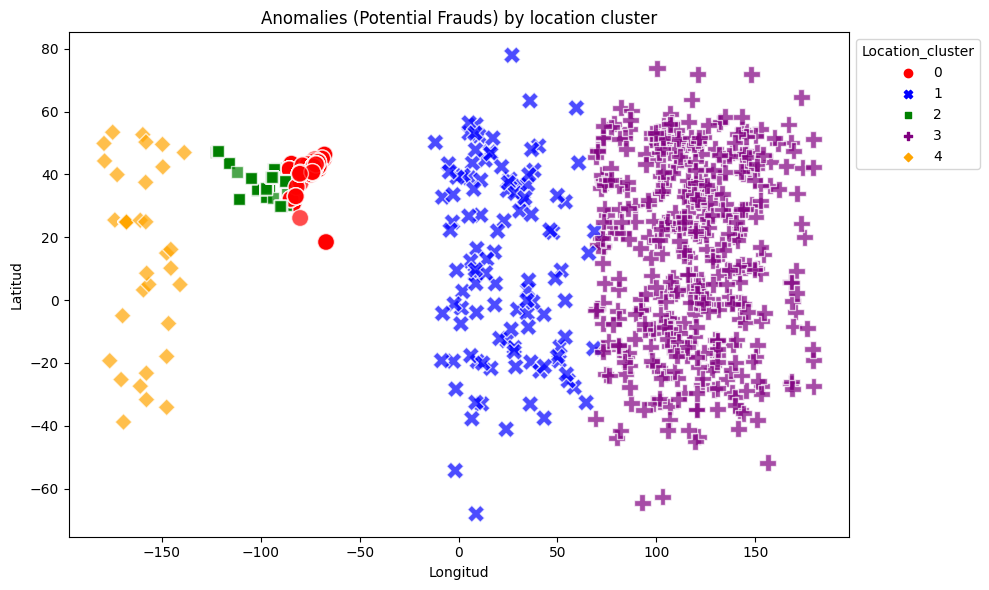

In [38]:
# Visualize anomalies within clusters
anomalies = merged_data[merged_data['is_anomaly'] == 1]

cluster_palette = ['red', 'blue', 'green', 'purple', 'orange']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Long',
    y='Lat',
    hue='location_cluster',
    style= 'location_cluster',
    data=anomalies,
    palette=cluster_palette,
    alpha=0.7,
    s=150
)

plt.legend(title= 'Location_cluster',bbox_to_anchor=(1.00, 1), loc=2)

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Anomalies (Potential Frauds) by location cluster')

plt.tight_layout()

plt.show()

In [30]:
# Geographic location of the place where the anomalous transactions were made
map_center = [anomalies['Lat'].mean(), anomalies['Long'].mean()]

m = folium.Map(location=map_center, zoom_start=5)

marker_cluster = MarkerCluster().add_to(m)

cluster_colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'purple', 4: 'orange'}

for idx, row in anomalies.iterrows():
    cluster = row['location_cluster']
    color = cluster_colors.get(cluster, 'gray'), # Default color if the cluster is not in the dictionary
    folium.Marker(
        location=[row['Lat'], row['Long']],
        popup=f"Monto: {row['transaction_dollar_amount']}, Cluster: {cluster}",
        icon=folium.Icon(color=color)
    ).add_to(marker_cluster)

m

/tmp/ipykernel_31/98235768.py:16: UserWarning: color argument of Icon should be one of: {'beige', 'gray', 'red', 'orange', 'darkpurple', 'blue', 'purple', 'lightred', 'pink', 'lightgreen', 'darkgreen', 'white', 'cadetblue', 'darkblue', 'lightblue', 'darkred', 'lightgray', 'black', 'green'}.
  icon=folium.Icon(color=color)


In [31]:
# Calculation of descriptive statistics for anomalies by cluster
cluster_stats = anomalies.groupby('location_cluster')[['transaction_dollar_amount', 'distance_to_city_km', 'hour', 'day_of_week', 'amount_to_limit']].agg(['mean', 'median', 'min', 'max'])

# Show statistics
cluster_stats

transaction_dollar_amount                                \
                                      mean    median       min       max   
location_cluster                                                           
0                                 6.088158  6.643681 -0.570489  7.369918   
1                                 2.395061  0.516530 -0.638437  7.224107   
2                                 3.044135  1.405183 -0.688976  7.364357   
3                                 0.222251 -0.112742 -0.689459  7.216530   
4                                 1.000950 -0.284749 -0.685832  7.334211   

                 distance_to_city_km                                           \
                                mean        median          min           max   
location_cluster                                                                
0                        1342.984528    656.158006     1.012406   5885.501930   
1                       10832.183954  10613.558151  1045.293054  18883.377756   
2                          50.195021      6.767852     0.277621   2291.971239   
3                       12907.065892  12814.967262  6052.119349  19648.259156   
4                        3077.349534   1117.008270  1104.507136  15440.253618   

                       hour                day_of_week                 \
                       mean median min max        mean median min max   
location_cluster                                                        
0                  9.595556    3.0   0  23    3.231111    4.0   0   6   
1                 11.548673   16.0   0  23    3.442478    4.0   0   6   
2                 10.063973    4.0   0  23    3.562290    4.0   0   6   
3                 14.117647   18.0   0  23    3.070588    3.0   0   6   
4                  6.842105    1.0   0  23    3.701754    5.0   0   6   

                 amount_to_limit                                 
                            mean    median       min        max  
location_cluster                                                 
0                       6.528112  4.953926 -0.448392  37.244245  
1                       2.001076  0.113698 -0.485239  21.599559  
2                       2.573496  0.883839 -0.504098  33.511078  
3                       0.193019 -0.139871 -0.504975   7.802135  
4                       1.010840 -0.169185 -0.502875   8.953973

In [32]:
distance_stats = merged_data.groupby(['location_cluster', 'is_anomaly'])['distance_to_city_km'].describe()
print(distance_stats)

                                count          mean          std          min  \
location_cluster is_anomaly                                                     
0                0           194302.0    938.646502   873.679645     0.025687   
                 1              900.0   1342.984528  1343.362807     1.012406   
1                0             1792.0   9054.666297  2420.589543   814.121587   
                 1              113.0  10832.183954  3076.424696  1045.293054   
2                0            14911.0     98.656321   443.007803     0.080100   
                 1              594.0     50.195021   307.443598     0.277621   
3                0              640.0  11246.521709  2671.933211  5038.176275   
                 1              425.0  12907.065892  2929.421619  6052.119349   
4                0              795.0   1464.566001  1468.285384  1104.178331   
                 1              114.0   3077.349534  3534.313052  1104.507136   

                           

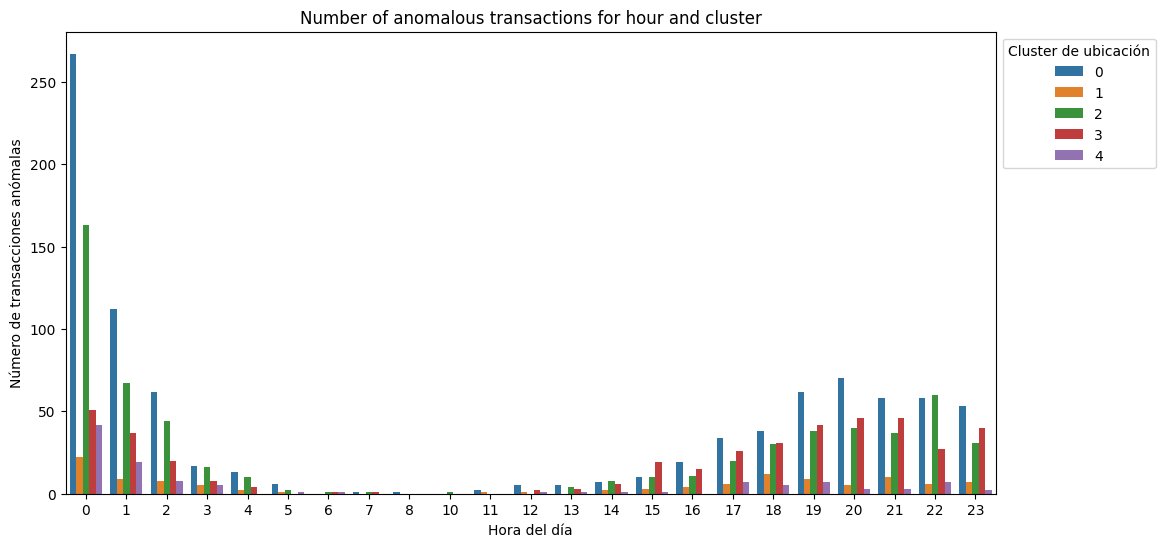

In [39]:
# Chart of Number of Anomalous Transactions by Hour and Cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='location_cluster', data=anomalies, palette='tab10')
plt.xlabel('Hora del día')
plt.ylabel('Número de transacciones anómalas')
plt.legend(title='Cluster de ubicación', bbox_to_anchor=(1.00, 1), loc=2)
plt.title('Number of anomalous transactions for hour and cluster')

plt.show()

In [33]:
'''
This is an example of code where some fraud detection rules could be implemented, in this case they would be clusters 1 and 4.
'''
# Filter suspicious transactions in the cluster 1
cluster_1_suspicious = data[
    (data['location_cluster'] == 1) &
    (data['distance_to_city_km'] > 13062) &
    (data['transaction_dollar_amount'] > 5) &  # Escala estandarizada
    (data['amount_to_limit_ratio'] > 5) &      # Escala estandarizada
    (data['hour'].between(0, 5)) &
    (data['day_of_week'].isin(['Friday', 'Saturday', 'Sunday']))
]

# Filter suspicious transactions in the cluster 3
cluster_4_suspicious = data[
    (data['location_cluster'] == 3) &
    (data['distance_to_city_km'] > 10480) &
    (data['transaction_dollar_amount'] > 5) &  # Escala estandarizada
    (data['amount_to_limit_ratio'] > 3) &      # Escala estandarizada
    (data['hour'].between(0, 5)) &
    (data['day_of_week'].isin(['Friday', 'Saturday', 'Sunday']))
]

# Combine suspicious transactions
suspicious_transactions = pd.concat([cluster_1_suspicious, cluster_3_suspicious])

# Save suspicious transactions to a CSV file for later analysis
suspicious_transactions.to_csv('suspicious_transactions.csv', index=False)
print(f"Se identificaron {len(suspicious_transactions)} transacciones sospechosas.")

NameError: name 'data' is not defined

Thanks Abhishek Sharma (Owner) for sharing this dataset.